In [18]:
# Import modules
import math # for floor()
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sp
import matplotlib.pyplot as plt

In [19]:
# Get the data into a Pandas dataframe
csv_file = "WSF12.csv"
wsf12_df = pd.read_csv( csv_file, comment='#' )
wsf12_df

,subj.num,secs.since.peak,avg.signal,sd.signal,mean,sd,z
0,12,0.0,1.073856,0.102809,0.01636,1.126732,0.938552
1,12,0.1,0.802451,0.108178,0.01636,1.126732,0.697674
2,12,0.2,0.670755,0.070639,0.01636,1.126732,0.580790
3,12,0.3,0.859836,0.100967,0.01636,1.126732,0.748604
4,12,0.4,0.492105,0.125575,0.01636,1.126732,0.422234
5,12,0.5,-0.322689,0.129904,0.01636,1.126732,-0.300914
6,12,0.6,-1.457100,0.102606,0.01636,1.126732,-1.307729
7,12,0.7,-1.691220,0.054034,0.01636,1.126732,-1.515516
8,12,0.8,-1.404494,0.221255,0.01636,1.126732,-1.261040
9,12,0.9,0.182652,0.197742,0.01636,1.126732,0.147588


In [20]:
# Get all the data for subject 12
boolIdx = np.all([(wsf12_df['subj.num'] >= 12), (wsf12_df['subj.num'] <= 12), ((wsf12_df['subj.num']%1) == 0)], axis=0)
subset_df = wsf12_df.loc[boolIdx,:].copy()
subset_df

,subj.num,secs.since.peak,avg.signal,sd.signal,mean,sd,z
0,12,0.0,1.073856,0.102809,0.01636,1.126732,0.938552
1,12,0.1,0.802451,0.108178,0.01636,1.126732,0.697674
2,12,0.2,0.670755,0.070639,0.01636,1.126732,0.580790
3,12,0.3,0.859836,0.100967,0.01636,1.126732,0.748604
4,12,0.4,0.492105,0.125575,0.01636,1.126732,0.422234
5,12,0.5,-0.322689,0.129904,0.01636,1.126732,-0.300914
6,12,0.6,-1.457100,0.102606,0.01636,1.126732,-1.307729
7,12,0.7,-1.691220,0.054034,0.01636,1.126732,-1.515516
8,12,0.8,-1.404494,0.221255,0.01636,1.126732,-1.261040
9,12,0.9,0.182652,0.197742,0.01636,1.126732,0.147588


In [21]:
# Import the things we'll need
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [22]:
x = subset_df["secs.since.peak"]
y = 1000* subset_df["z"]
y_var = y

In [23]:
# Construct a kernel, setting an intial length and amplitude
# Ideally these should be (perhaps crudely) estimated from data
initial_ell = (np.amax(x) - np.amin(x)) / 10
initial_scale = np.var( y ) 
rbf_kernel = initial_scale * RBF(length_scale=initial_ell, 
    length_scale_bounds=(initial_ell/20, 5 * initial_ell))

# Consrtuct the GP object: note the way the uncertainty in y_train enters
gp = GaussianProcessRegressor( kernel=rbf_kernel, alpha=y_var )

In [24]:
# Fit things
x_vec = x[:, np.newaxis] # makes x into a column vector
gp.fit( x_vec, y )

# Get the fitted A and ell from the posterior
fitted_kernel = gp.kernel_
fitted_params = fitted_kernel.get_params()
A = math.sqrt( fitted_params["k1__constant_value"] )
ell = fitted_params["k2__length_scale"]

In [25]:
xVals = np.linspace( 0, 1.0)

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:380: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


Text(0.5, 0, 'Seconds since peak')

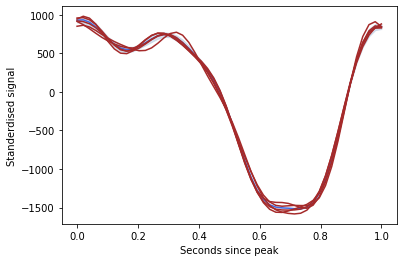

In [26]:
# Make predictions at positions listed in a vector xVals
xVal_vec = xVals[:, np.newaxis] # Build the N-by-1 array
y_mean, y_std = gp.predict(xVal_vec, return_std=True)

# Plot the mean with a +/- one std_dev shaded band
plt.plot( xVals, y_mean, color="royalblue" )
plt.fill_between(xVals, y_mean - y_std, y_mean + y_std, alpha=0.5, color="lightsteelblue" )

# Construct and plot random functions drawn from the posterior
nSamples = 5
y_samples = gp.sample_y( xVal_vec, nSamples )
plt.plot( xVals, y_samples, color="brown" )
plt.ylabel ('Standerdised signal')
plt.xlabel ('Seconds since peak')

In [27]:
# Construct some random functions sampled from the posterior
nSamples = 6
y_samples = gp.sample_y( xVal_vec, nSamples )

# Print the values of the first sample
print( y_samples[:,1])
print( y_samples[:,2])
print( y_samples[:,3])
print( y_samples[:,4])
print( y_samples[:,5])

[  959.27549311   964.12781367   936.04365432   876.07528831
   791.37277884   695.53012731   607.39440068   546.85084222
   528.03734446   553.05841459   610.09816659   677.69878393
   733.22471456   761.00302165   756.18134159   723.32784822
   671.77555145   610.6736515    545.61098603   477.05843753
   400.16258741   305.72957308   182.65119883    21.7563469
  -179.81112855  -415.37218224  -668.35432469  -915.56620538
 -1133.31659711 -1304.12794302 -1421.29259099 -1489.44717709
 -1521.24553407 -1531.86828636 -1533.51108199 -1531.26718288
 -1520.99351447 -1489.57828006 -1418.16496038 -1288.36081898
 -1089.92036255  -826.80251448  -518.40197436  -194.7980734
   112.02035427   376.85645454   586.09054226   737.1087691
   833.89177674   882.0126953 ]
[  852.03131315   865.01773307   842.64502441   798.00730795
   745.55002747   696.03763508   653.57873879   616.64945819
   582.60545246   552.75641317   534.44284838   538.23577882
   571.36932588   631.01312826   701.50762024   757.8676

C:\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:380: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


In [28]:
print(gp.predict)

<bound method GaussianProcessRegressor.predict of GaussianProcessRegressor(alpha=0      938.551736
1      697.673660
2      580.789848
3      748.604235
4      422.234446
5     -300.913519
6    -1307.728661
7    -1515.516032
8    -1261.039955
9      147.588107
10     849.759333
Name: z, dtype: float64,
                         copy_X_train=True,
                         kernel=898**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)>


Text(0.5, 0, 'Z scores for seconds since peak')

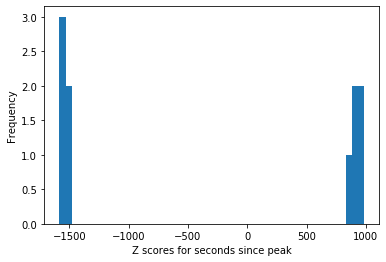

In [29]:
x = [964.12781367, -1533.51108199, 865.01773307,-1583.11950067,  982.01431715, -1563.64073265, 920.5636294, -1509.44489857, 922.01277104, -1515.08176842]
plt.hist (x, bins = 50)
plt.ylabel ('Frequency')
plt.xlabel ('Z scores for seconds since peak')